In [53]:
# Study Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc,  make_scorer, recall_score, roc_auc_score

# Data preparation Libs
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import optuna
from sklearn.pipeline import Pipeline

# ML Libs
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## Discovery

In [19]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [20]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [22]:
df.duplicated().sum()

np.int64(1081)

We'll drop the duplicate, same amount, same caracteristics, same time... yeah...

In [23]:
df.drop_duplicates(inplace=True)

In [24]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [25]:
print('Frauds', round(len(df[df['Class'] == 1])/len(df) * 100,2), '% of the dataset')
print('No Frauds', round(len(df[df['Class'] == 0])/len(df) * 100,2), '% of the dataset')

Frauds 0.17 % of the dataset
No Frauds 99.83 % of the dataset


**Information:** Wow We have a huge disproportion here, we'll have to consider it during our ML phase.

## Exploration

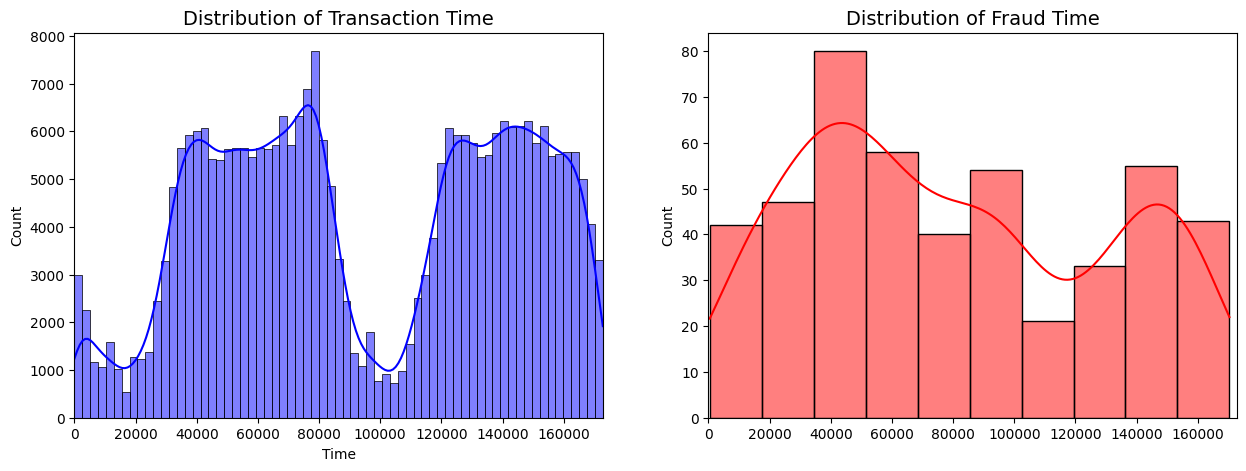

In [26]:
# Let's study the time!
# Time distribution:

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.histplot(df['Time'], color='b', kde=True)
plt.title('Distribution of Transaction Time', fontsize=14)
plt.xlim(min(df['Time']),max(df['Time']))

# Fraud distribution over time
plt.subplot(1,2,2)
sns.histplot(df[df['Class']==1]['Time'].values, color='r', kde=True)
plt.title('Distribution of Fraud Time', fontsize=14)
plt.xlim(min(df['Time']),max(df['Time']))

plt.show()

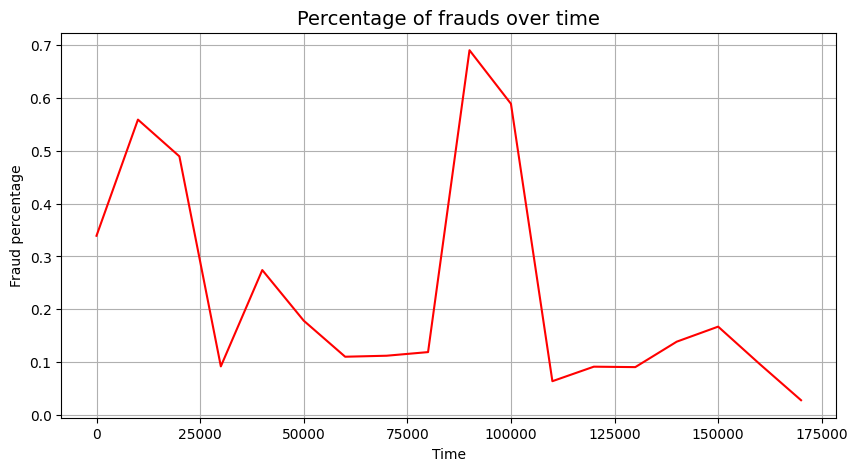

In [27]:
# We'll try to have the proportion of frauds by slices of time.

# We create bins of 10000s
bin_width = 10000
df['Time_bin'] = (df['Time'] // bin_width) * bin_width

# Now we calculate the percentage of frauds by time bin
fraude_ratio = df.groupby('Time_bin')['Class'].agg(['count', 'sum'])
fraude_ratio['fraude_ratio'] = (fraude_ratio['sum'] / fraude_ratio['count'])*100

# Let's plot!
plt.figure(figsize=(10,5))
sns.lineplot(x=fraude_ratio.index, y=fraude_ratio['fraude_ratio'], color='red')
plt.title('Percentage of frauds over time', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Fraud percentage')
plt.grid(True)
plt.show()

**Information:** Okay! So the proportion seems to be more important at times where there is fewer transactions. It was kind of predictable by looking at the thin difference of fraud count in the previous graph but heh, now we know!

Amount infos
count    283726.000000
mean         88.472687
std         250.399437
min           0.000000
25%           5.600000
50%          22.000000
75%          77.510000
max       25691.160000
Name: Amount, dtype: float64
Amount infos on Fraud transactions
count     473.000000
mean      123.871860
std       260.211041
min         0.000000
25%         1.000000
50%         9.820000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


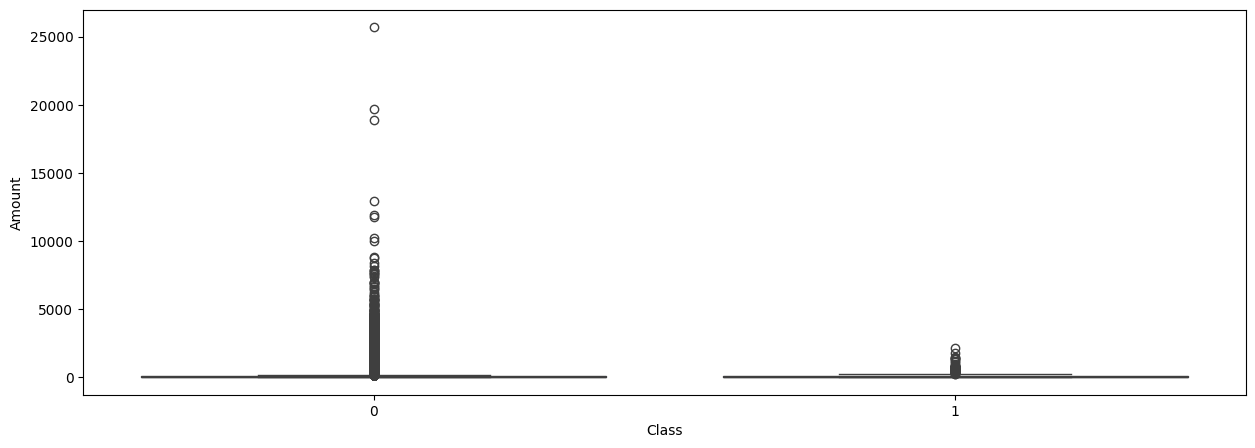

In [28]:
# Let's talk about amounts now!
print('Amount infos')
print(df['Amount'].describe())
print('Amount infos on Fraud transactions')
print(df[df['Class']==1]['Amount'].describe())

plt.figure(figsize=(15,5))
sns.boxplot(data = df, x='Class', y='Amount')
# plt.ylim(-100, max(df[df['Class']==1]['Amount'])+200)
plt.show()

**Information:** Ok on global the mean and median of transactions are quite low. The STD is quite similar between Fraud and not Fraud. The mean and median is higher in the Fraud section however. A bit informative but not too much here...

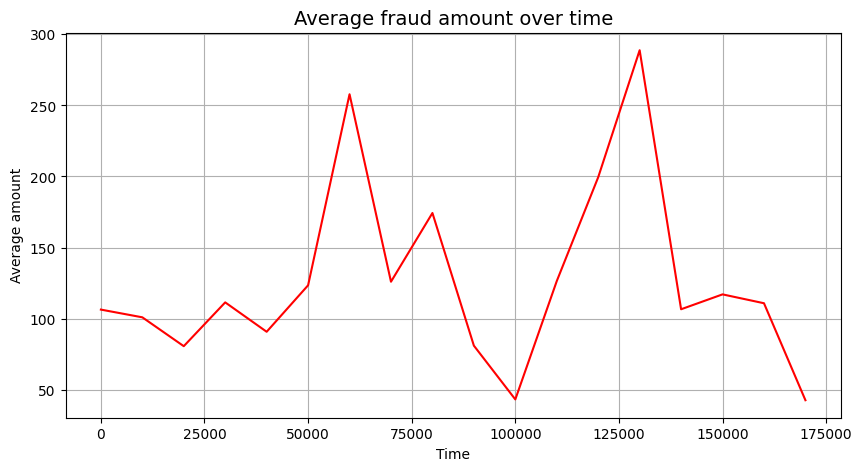

In [29]:
# We'll try to have the proportion of frauds by slices of time.

# We create bins of 10000s
bin_width = 10000
df['Time_bin'] = (df['Time'] // bin_width) * bin_width

# Now we calculate the percentage of frauds by time bin
fraud_amount = df[df['Class'] ==1].groupby('Time_bin')['Amount'].agg(['mean'])
# fraude_amount['fraude_amount'] = (fraude_ratio['sum'] / fraude_ratio['count'])*100

# Let's plot!
plt.figure(figsize=(10,5))
sns.lineplot(x=fraud_amount.index, y=fraud_amount['mean'], color='red')
plt.title('Average fraud amount over time', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Average amount')
plt.grid(True)
plt.show()

## Features exploration

**Let's talk about features!**

Now we'll talk about feature importance. We'll try to understand which feature has an influence on the target.
To do that we'll have to change the propotion to avoid the noise of the vast majority of non fraud.
We'll have to SPLIT!
Why? We want something robust, precise, so we'll make our study on a train set, 
leaving our test set out to have a maximum of reality coming into our model during the final prediction.

*BUT*

We have to do it properly. We have time stamps so if we shuffle and stratify we'll creat time bias by giving our model information from the future for predicting transactions in the past. We don't want that.
We'll split manually, choosing the "Time" section to only the 80% past and 20% future as train/test.
We'll have to check the proportion however, if we don't have enough frauds in the test set won't be able to measure the effectiveness of our model.

In [30]:
df_sorted = df.sort_values(by="Time", ascending = True)
split_index = int(len(df_sorted)*0.8)
train_df = df_sorted[:split_index]
test_df = df_sorted[split_index:]

In [46]:
X_original_train = train_df.drop(columns=['Class', 'Time_bin'])
y_original_train = train_df['Class']
print('In train set we have:')
print('Frauds', round(len(y_original_train[y_original_train == 1])/len(y_original_train) * 100,2), '% of the dataset')
print('No Frauds', round(len(y_original_train[y_original_train == 0])/len(y_original_train) * 100,2), '% of the dataset')


X_original_test = test_df.drop(columns=['Class', 'Time_bin'])
y_original_test = test_df['Class']
print('In test set we have:')
print('Frauds', round(len(y_original_test[y_original_test == 1])/len(y_original_test) * 100,2), '% of the dataset')
print('No Frauds', round(len(y_original_test[y_original_test == 0])/len(y_original_test) * 100,2), '% of the dataset')

In train set we have:
Frauds 0.18 % of the dataset
No Frauds 99.82 % of the dataset
In test set we have:
Frauds 0.13 % of the dataset
No Frauds 99.87 % of the dataset


Ok the proportions are decent enough to work with!

In [32]:
# Let's scale the time and amout! We use Robust scaler, he is more robust with the presence of outliers

scaler= RobustScaler()

X_rescaled = scaler.fit_transform(X_original_train[['Amount', 'Time']])
X_rescaled = pd.DataFrame(X_rescaled, columns=['scaled_amount', 'scaled_time'], index=X_original_train.index)
X_original_train = pd.concat([X_original_train, X_rescaled], axis=1)
X_original_train.drop(columns=['Amount', 'Time'], inplace= True)
display(X_original_train.tail(3))

# Ok now for the test part! We only transform her, no data leak!

X_rescaled_t = scaler.transform(X_original_test[['Amount', 'Time']])
X_rescaled_t = pd.DataFrame(X_rescaled_t, columns=['scaled_amount', 'scaled_time'], index=X_original_test.index)
X_original_test = pd.concat([X_original_test, X_rescaled_t], axis=1)
X_original_test.drop(columns=['Amount', 'Time'], inplace= True)
display(X_original_test.tail(3))

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
227816,2.111468,-0.607619,-0.972739,0.010592,-0.782027,-1.225196,-0.200564,-0.407590,-0.162631,0.646272,...,-0.162889,0.373515,0.075393,0.496001,0.245824,-0.085769,0.022953,-0.049552,-0.162027,0.989954
227818,2.045329,-0.127557,-1.084864,0.432121,-0.219836,-1.233060,0.147543,-0.297332,0.647602,0.090351,...,-0.291890,-0.759998,0.342628,0.027266,-0.326637,0.196891,-0.076917,-0.059947,-0.182432,0.989954
227819,-0.861465,-0.149128,1.523218,-1.598932,-1.904715,0.400161,1.334304,-0.341400,-1.277563,-0.270898,...,0.402892,1.210480,-0.211676,0.063405,0.635125,0.132667,0.068426,-0.022504,4.250135,0.989968


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0.599865,1.369042
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,-0.182297,1.369042
284806,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,2.615000,1.369097


Now that we have split, we can play on the train, we will start by evaluating the feature importance.
We will start with the ROC AUC. The advantage of the ROC AUC is that our class imbalance is not a problem with this metric.

*What is it?*
The Univariate AUC analysis measures the capacity of target class separation of a feature.
The analysis tests multiples thresholds (a threshold is a value of our feature in general) on the feature and ask the question: 
"Will my target will be 1 if the feature is above this thershold?"
Like a simple classifier, it then give us True Positive Rates (TPR) and False Positive Rates (FPR) and then it plots the TPR against the FPR.

*How do we read it?*
We have a curve and we take the Area Under the Curve. If this area is close to 1, the feature is a great separator.
If the area is 0.5, it's pure random.
If the area is lower than 0.5, the more it goes to 0 the more we should do the opposite of the feature to make a good separation.

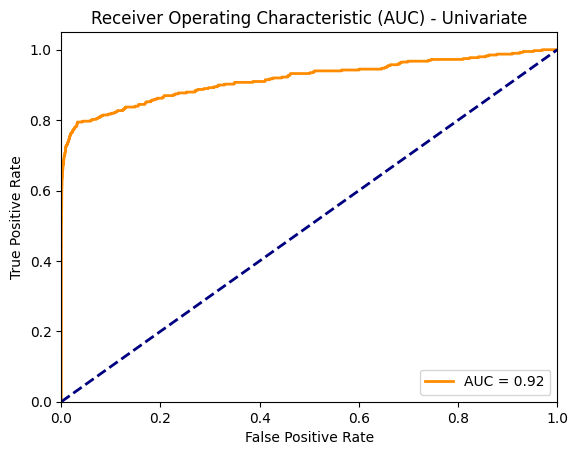

In [33]:
# Exemple avec la feature 'V14' et les labels 'y'
fpr, tpr, thresholds = roc_curve(y_original_train, X_original_train['V11'])
roc_auc = auc(fpr, tpr)

# Tracer la ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (AUC) - Univariate')
plt.legend(loc='lower right')
plt.show()

In [34]:
df_roc_auc = pd.DataFrame()
i=0
for col in X_original_train.columns:
    fpr, tpr, thresholds = roc_curve(y_original_train, X_original_train[col])
    roc_auc = auc(fpr, tpr)
    df_roc_auc.loc[i, 'Cols'] = col
    df_roc_auc.loc[i, 'ROC_AUC'] = roc_auc
    i+= 1
display(df_roc_auc.sort_values('ROC_AUC', ascending= False))

,Cols,ROC_AUC
3,V4,0.937179
10,V11,0.916463
1,V2,0.859818
20,V21,0.739196
26,V27,0.707871
18,V19,0.671690
7,V8,0.665755
19,V20,0.648557
27,V28,0.632775
25,V26,0.529638


Now we'll try something else. The Pearson correlation. The problem with that is that we have a heavily imbalanced dataset.
To avoid noise we'll have to balance this.

*How?*
Undersampling. We'll create a smaller df with all the frauds and the same number of non-fraud. It will help us to have a clearer view of the correlation
BUT!
Doing that we'll have a huge bias, the random sample of non fraud used may be extremely specific and give us misleading correlations.

*What do we do?*
First we have the ROC AUC. If we have a huge problem we'll see it.
Secondly won't use only the undersampler created. We'll create 10-15 different undersampled datasets (because of the dataset size) and a correlation matrix for each.
Then, we'll calculate the average correlation matrix using all the previous matrixes.

In [35]:
df_train = pd.concat((X_original_train,y_original_train), axis = 1)

frauds = df_train[df_train['Class'] == 1]
non_frauds = df_train[df_train['Class'] == 0]

# Let's go with 10 samples
num_samples = 10

# We'll stock our cute little dataframes here
undersampled_datasets = []

for i in range(num_samples):
    # Non fraud collection
    non_frauds_sample = non_frauds.sample(n=len(frauds), random_state=i)
    
    # Balanced dataset creation
    undersampled_df = pd.concat([frauds, non_frauds_sample])
    
    # Adding the ne dataset to the list
    undersampled_datasets.append(undersampled_df)

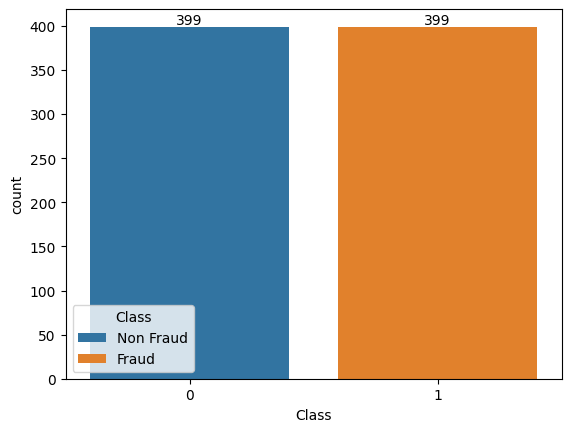

In [36]:
# Let's check our repartition on the first dataset of the list
ax =sns.barplot(data=undersampled_datasets[0]['Class'].value_counts().reset_index(), x='Class', y='count', hue= 'Class')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

new_labels = ['Non Fraud', 'Fraud']
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=new_labels, title='Class')
plt.show()

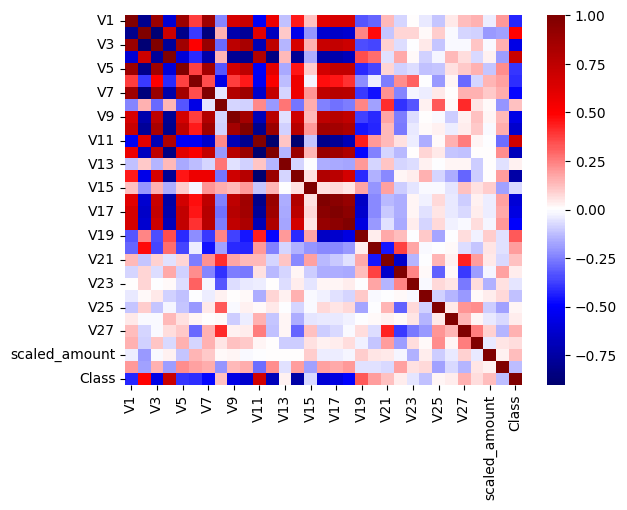

In [37]:
# Let's look at a heatmap!

sns.heatmap(data= undersampled_datasets[0].corr(), cmap = "seismic", center = 0)
plt.show()

Nice carpet. Now we'll take the line of the correlation matrix corresponding to the class

In [38]:
corr_matrix_0 = undersampled_datasets[0].corr()['Class']
display(corr_matrix_0.sort_values(ascending = False).drop('Class'))

V4               0.705245
V11              0.684916
V2               0.493267
V19              0.316927
V20              0.190388
V27              0.153677
scaled_amount    0.123576
V8               0.121039
V21              0.116134
V28              0.065062
V26              0.037027
V22              0.036537
V13              0.025705
V25              0.021121
V23             -0.053474
V15             -0.076441
V24             -0.119025
scaled_time     -0.127443
V5              -0.394747
V6              -0.407261
V1              -0.422762
V7              -0.483734
V18             -0.500432
V3              -0.563072
V9              -0.564378
V17             -0.580237
V16             -0.613588
V10             -0.635008
V12             -0.687851
V14             -0.744368
Name: Class, dtype: float64

It really look like the order of the ROC AUC Score, we're not out of the blue!

In [39]:
# Now we'll make the average correlation matrix

df_matrix= pd.DataFrame()
for mini_df in undersampled_datasets:
    matrix =  mini_df.corr()['Class'].drop('Class')
    df_matrix = pd.concat((df_matrix,matrix), axis = 1)

df_matrix_mean = df_matrix.T.mean()
display(df_matrix_mean.sort_values(ascending=False))

V4               0.706541
V11              0.685535
V2               0.504746
V19              0.288011
V20              0.181225
V27              0.139401
V8               0.127758
V21              0.113786
scaled_amount    0.079234
V28              0.063925
V22              0.055578
V26              0.031233
V25              0.014959
V13             -0.011102
V23             -0.052925
V15             -0.058597
V24             -0.078000
scaled_time     -0.161744
V5              -0.403519
V6              -0.424228
V1              -0.438829
V7              -0.487644
V18             -0.490961
V9              -0.551572
V3              -0.565870
V17             -0.577226
V16             -0.612592
V10             -0.639008
V12             -0.688263
V14             -0.745995
dtype: float64

Ok, Everything seems to be coherent here.

## Machine Learning

We'll use XGBoost as a model, and his argument scale_pose_weight to adapt to the imbalaced situation.
So i have to calculate it by making the division of the proportions:

In [51]:
count_neg = y_original_train.value_counts(1)[0]
count_pos = y_original_train.value_counts(1)[1]
spw =  count_neg/count_pos
print(spw)

567.8721804511279


Now for the choice of the parameters we'll try to use the optuna library!
So we'll work this way:
We'll make a cross validation with 5 splits on the train set.
 -Each split will be time series splits (to preserve the chronology) on our train set
 -We'll scale the split
 -We'll fit our model
 -We'll calculate the roc auc score
And we let optuna get the best params!

In [59]:
TSC_CV = TimeSeriesSplit(n_splits=5)
#Necessary Optuna Metric
auc_scorer = make_scorer(roc_auc_score, response_method='predict_proba')

In [ ]:
def objective_with_pipeline(trial, X, y, cv_splitter, sp_weight, metric_scorer):
    """Fonction objectif Optuna avec Pipeline : maximise l'AUC-ROC via TimeSeriesSplit."""

    # 2. Hyperparameters search
    param = {
        # Tree construction
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
        
        # Overfitting gestion
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 1.0),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-1, 10.0),
        
        # Sous-échantillonnage (variance)
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        
        # Constantes
        'objective': 'binary:logistic',
        'random_state': 42,
        'scale_pos_weight': sp_weight # Of course
    }

    # 3. Model and pipelinee
    xgb_model = XGBClassifier(
        **param,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    # Le Pipeline garantit que le RobustScaler est FIT sur chaque pli d'entraînement
    model_pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('xgb', xgb_model)
    ])

    # 4. Évaluation par validation croisée temporelle
    # On passe X_train_xgb (non mis à l'échelle) au pipeline
    scores = cross_val_score(
        model_pipeline,  
        X,              
        y,              
        cv=cv_splitter,
        scoring=metric_scorer,
        n_jobs=-1
    )

    return scores.mean()


# 5. Lancement de l'étude Optuna
# ATTENTION : Décommentez pour lancer l'exécution. Ajustez n_trials (ex: 100 pour une bonne recherche).
study = optuna.create_study(direction='maximize')
study.optimize(
    lambda trial: objective_with_pipeline(trial, X_original_train, y_original_train, TSC_CV, spw, auc_scorer),
    n_trials=100, # Nombre d'essais
    show_progress_bar=True
)


[I 2025-10-09 11:25:28,159] A new study created in memory with name: no-name-b9afb37a-09cb-41db-9266-c29c7ccc5a59


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\nicol\AppData\Local\Temp\ipykernel_5284\2103036332.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
C:\Users\nicol\AppData\Local\Temp\ipykernel_5284\2103036332.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-3, 1.0),
C:\Users\nicol\AppData\Local\Temp\ipykernel_5284\2103036332.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_chi

[I 2025-10-09 11:25:51,487] Trial 0 finished with value: 0.9745078684216445 and parameters: {'n_estimators': 595, 'max_depth': 7, 'learning_rate': 0.06365583488977025, 'gamma': 0.03443669613046757, 'min_child_weight': 1.0396470483510232, 'subsample': 0.7204551348645144, 'colsample_bytree': 0.6391391500043857}. Best is trial 0 with value: 0.9745078684216445.


In [61]:
# # Récupération des meilleurs paramètres
BEST_PARAMS = study.best_params
print(f"AUC-ROC moyenne (Validation Croisée) : {study.best_value:.4f}")
print(f"Meilleurs hyperparamètres trouvés : {BEST_PARAMS}")

AUC-ROC moyenne (Validation Croisée) : 0.9745
Meilleurs hyperparamètres trouvés : {'n_estimators': 595, 'max_depth': 7, 'learning_rate': 0.06365583488977025, 'gamma': 0.03443669613046757, 'min_child_weight': 1.0396470483510232, 'subsample': 0.7204551348645144, 'colsample_bytree': 0.6391391500043857}
